<a href="https://colab.research.google.com/github/john-reilly/RoboFarm/blob/master/Apples_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
base_dir = '/content/gdrive/My Drive/'

In [0]:
#REQUIREMENTS 
!Flask==0.11.1
!attrdict==2.0.0
!eventlet==0.19.0
!numpy==1.13.1
!scipy==0.19.1
!keras==2.0.8
!tensorflow==1.3.0
!h5py==2.6.0
!pandas==0.24.2
!Pillow==2.8.0

In [0]:
import os
import random
import time

import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps


class ObjectDetector:

    def __init__(self,location_path = base_dir, graph_filename = 'frozen_inference_graph.pb' ):       
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            try:
                with tf.gfile.GFile( location_path + graph_filename, 'rb') as fid:
                    serialized_graph = fid.read()
                    od_graph_def.ParseFromString(serialized_graph)
                    tf.import_graph_def(od_graph_def, name='')
                    self.session = tf.Session(graph=self.detection_graph)
            except Exception as e:
                print(e)
                exit()


    def run_inference_for_single_image(self, image, show_stats = True ):
        # Get handles to input and output tensors
        ops = self.detection_graph.get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = self.detection_graph.get_tensor_by_name(tensor_name)
        image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0') #indentation?

        # Run inference
        start = time.time()
        output_dict = self.session.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})
        elapsed = time.time() - start
        #print('inference took:', elapsed, ' seconds') 
        
        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]

        if show_stats == True:
          print('inference took:', elapsed, ' seconds') 
          print("num_detections:" , output_dict['num_detections'])
          print("Detection Classes: " , output_dict['detection_classes'])
          print("Detection Scores: " , output_dict['detection_scores'])

        return output_dict

    def overlay_bounding_boxes(self, image, output_dict,detection_class, probability_level, draw_boxes = False):
        classes = output_dict['detection_classes']
        boxes = output_dict['detection_boxes']
        scores = output_dict['detection_scores']

        height, width, _ = image.shape

        tf_boxes = []
        output_images = []
        for i in range(len(boxes)):
            confidence = float(scores[i])
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            box_width = xmax - xmin
            box_height = ymax - ymin
            box_ratio = float(box_height) / box_width 
            #filter criteria
            if confidence >= probability_level and \
              classes[i] == detection_class :
                # also possible and \  #box_ratio >= 0.75     #box_width > 21   #box_height > 20
                #draw rectanlge around object having this here interferes with later on as cropped images have rectanlge over writes
                if draw_boxes:
                  cv2.rectangle(image, (xmin,ymin) , (xmax, ymax) , (255,0,0) ,2)
                #record object data
                tf_boxes.append(boxes[i])
                #crop object out of image for further processing
                crop_image = image[ymin:ymax, xmin:xmax]
                crop_output_image = Image.fromarray(crop_image)
                output_images.append(crop_output_image)
                
        return image, tf_boxes , output_images



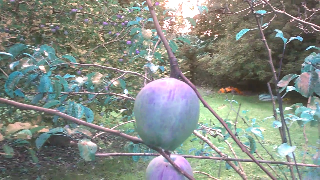

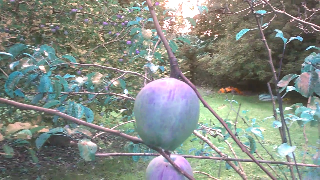

In [6]:

from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project
import cv2

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
frame = clip1.get_frame(3)#3) #19

#Before processing
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


my_detector = ObjectDetector(base_dir , 'frozen_inference_graph.pb')
output_dict = my_detector.run_inference_for_single_image(frame, show_stats = False) # True)
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
final_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.04, draw_boxes = False ) #True)
#After processing
#cv2_imshow(final_image)
cv2_imshow( cv2.resize(final_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


In [8]:
#TRAIN.py
# Load the data

import gzip
import re
import os

import numpy as np
import pandas as pd
from time import time
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.backend import tensorflow_backend as ktf
from pathlib import Path

from os import listdir
from os.path import isfile, join


apple_type = ['ripe', 'not_ripe']
apple_type_categories = [[1,0], [0,1]]

RESIZED_DIR = base_dir + 'data/' + 'Ripe_not_ripe/' + 'images_resized/'

def read_images(images_path):
    labels = []
    features = []
    for root, dirs, files in os.walk(images_path, topdown=False):
        
        path = os.path.dirname(images_path + 'images_resized/')
        Path(path).mkdir(exist_ok=True)
        
        for filename in files:
            added = False
        
            for index, color in enumerate(apple_type):              
                labels.append(apple_type_categories[index])
                print(images_path + apple_type[index]+ '/' + filename)
                img = load_img(images_path + apple_type[index]+ '/' + filename)
                img = crop_image(img)
                img.save('{}{}{}'.format(RESIZED_DIR,  apple_type[index]+ '/' ,filename), 'JPEG')
                x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) 
                features.append(x)
                added = True
                break
            if not added:
                print('Error invalid filename:', filename)

    return np.array(features), np.array(labels)

def preprocess_images(images_path):
  
    if not os.path.exists(images_path + 'preprocessed/' + 'ripe/' ):
      os.makedirs(images_path + 'preprocessed/' + 'ripe/' )
  
    for root, dirs, files in os.walk(images_path+'ripe/', topdown=True):    
      for filename in files:
        img = load_img(images_path + 'ripe/' + filename)
        img = crop_image(img)
        img.save(images_path + 'preprocessed/' + 'ripe/' + filename)


    if not os.path.exists(images_path + 'preprocessed/' + 'not_ripe/' ):
      os.mkdir(images_path + 'preprocessed/' + 'not_ripe/' )

    for root, dirs, files in os.walk(images_path+'not_ripe/', topdown=True):    
      for filename in files:
        img = load_img(images_path + 'not_ripe/' + filename)
        img = crop_image(img)
        img.save(images_path + 'preprocessed/' + 'not_ripe/' + filename)


def load_prepared_images(images_path):
  
  features = []
  labels = []

  for root, dirs, files in os.walk(images_path+'ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'ripe/' + filename)
      x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
      features.append(x)
      labels.append(apple_type_categories[0])


  for root, dirs, files in os.walk(images_path+'not_ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'not_ripe/' + filename)
      x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
      features.append(x)
      labels.append(apple_type_categories[1])
     

  return np.array(features), np.array(labels)


def remove_ext(filename):
    return re.sub(r'\.png|\.jpeg|\.jpg', '', filename, re.IGNORECASE)

def crop_image(img):
    img.thumbnail((32, 32), Image.ANTIALIAS)
    width, height = img.size
    delta_w = 32 - width
    delta_h = 32 - height
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    img = ImageOps.expand(img, padding, fill=0)  # fill with black dots
    return img



features, labels = load_prepared_images(base_dir + 'data/' + 'Ripe_not_ripe/' + 'preprocessed/')

train = {}
test = {}

train['features'], test['features'], train['labels'], test['labels'] = train_test_split(features, labels, test_size=0.05)

# explore the data

print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# plot training data
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
print(dataframe_train_labels)

# Split training data into training and validation
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

print(features.shape)
print(labels.shape)

print("Updated Image Shape: {}".format(train['features'][0].shape))

model = Sequential()

model.add(layers.Lambda(lambda x: x/255.0 - 0.5, input_shape=(32,32,3))) # added

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=2, activation = 'softmax')) #for 2 categories

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(train['features'], train['labels'], epochs=52, validation_split=0.3, shuffle=True, callbacks=[tensorboard])


score = model.evaluate(test['features'], test['labels'])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save(base_dir + 'apple_lenet_model.h5')

# of training images: 243
# of test images: 13
   Label  Count
0      0    243
1      1    243
# of training images: 194
# of validation images: 49
(256, 32, 32, 3)
(256, 2)
Updated Image Shape: (32, 32, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d_3 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_4 (Average (None, 6, 6, 16)          0         
_____________________________________________

In [0]:
#classify.py

import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
import time
import os

#class_model = load_model(base_dir + 'apple_lenet_model.h5')

#traffic_light_colors = ['ripe', 'not_ripe']

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class ObjectClassifier:

    def __init__(self,location_path = base_dir, model_name = 'apple_lenet_model.h5' ):       
  
            try:
              self.class_model = load_model(base_dir + 'apple_lenet_model.h5')
              
            except Exception as e:
                print(e)
                exit()

            self.traffic_light_colors = ['ripe', 'not_ripe']

    def predict(self,image_name):

        img = load_img(image_name, False, target_size=(32, 32))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        preds = self.class_model.predict_classes(x)
        prob = selfclass_model.predict_proba(x)

        return preds[0], prob[0]

    def predict_for_detected(self, image_name):
      
        resized_image = image_name.resize((32,32), resample=0)

        x = img_to_array(resized_image)
        x = np.expand_dims(x, axis=0)
        preds = self.class_model.predict_classes(x)
        prob = self.class_model.predict_proba(x)

        return preds[0], prob[0]

    def draw_positive_boxes(self,final_image,object_data, object_images, show_each_addition =  False ):

      height, width ,_ = final_image.shape #  as per PIL
      print('final_image.shape : ', final_image.shape)


      for   i in  range(0, len(object_images ) ) :
        start = time.time()
        pred, prob = self.predict_for_detected( object_images[i]) #originally self was not here then it gave trouble for no reason

        #plt.imshow(object_images[i])
        #plt.show()
        elapsed = time.time() - start
        print('Result: ', ':', self.traffic_light_colors[pred], '- prodb:', prob, '-elapsed time:', elapsed, ' s')

        if pred == 0 :
          ymin, xmin, ymax, xmax = tuple(object_data[i].tolist())#tuple(boxes[i].tolist())
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)
          ymin = int(ymin * height)
          ymax = int(ymax * height)
          xmin = int(xmin * width)
          xmax = int(xmax * width)
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)

          cv2.rectangle(final_image, (int(xmin),int(ymin)) , (int(xmax),int( ymax) ) , (255,0,0) ,2)
          if show_each_addition  :
            cv2_imshow(final_image)
            

          #return final_image # <-------------wrong indentation caused return only if apple sucessfully calssified

      return final_image

#show_each_addition = False
#last_image = draw_positive_boxes( final_image, object_data, object_images,  show_each_addition )

#total = 0 #not used?
#errors = 0



In [31]:
#the complete pipeline


from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project
import cv2

#clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
#frame = clip1.get_frame(3)#3) #19

#Before processing
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


my_detector = ObjectDetector(base_dir , 'frozen_inference_graph.pb')
my_classifier = ObjectClassifier(base_dir ,'apple_lenet_model.h5'  )


#pipeline


def pipeline(frame) :
  output_dict = my_detector.run_inference_for_single_image(frame, show_stats = False) # True)
  #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
  final_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.10, draw_boxes = False ) #True)
  #After processing
  #cv2_imshow(final_image)
  #cv2_imshow( cv2.resize(final_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )

  last_image = my_classifier.draw_positive_boxes(final_image, object_data,object_images)
  

  #cv2_imshow( cv2.resize(last_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) ) #fails here if no image or objects?
  
  return last_image #forgot this!!

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4').subclip(0,5)
output_clip = clip1.fl_image(pipeline)
output_clip.write_videofile(base_dir + 'output_clip_4.mp4', audio = False)



#white_output = 'test_videos_output\solidWhiteRight_After_Feedback.mp4'


final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.0213025e-07 9.9999964e-01] -elapsed time: 0.5155444145202637  s
Result:  : not_ripe - prodb: [4.2892145e-05 9.9995708e-01] -elapsed time: 0.003204345703125  s
Result:  : not_ripe - prodb: [3.6877525e-05 9.9996316e-01] -elapsed time: 0.0028994083404541016  s
Result:  : not_ripe - prodb: [7.690303e-09 1.000000e+00] -elapsed time: 0.0030488967895507812  s
Result:  : not_ripe - prodb: [2.6433563e-08 1.0000000e+00] -elapsed time: 0.002710103988647461  s
Result:  : not_ripe - prodb: [4.206654e-09 1.000000e+00] -elapsed time: 0.0027616024017333984  s
Result:  : not_ripe - prodb: [8.907139e-08 9.999999e-01] -elapsed time: 0.002560853958129883  s
[MoviePy] >>>> Building video /content/gdrive/My Drive/output_clip_4.mp4
[MoviePy] Writing video /content/gdrive/My Drive/output_clip_4.mp4



  1%|          | 1/151 [00:00<00:32,  4.68it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.0213025e-07 9.9999964e-01] -elapsed time: 0.0049915313720703125  s
Result:  : not_ripe - prodb: [4.2892145e-05 9.9995708e-01] -elapsed time: 0.0030341148376464844  s
Result:  : not_ripe - prodb: [3.6877525e-05 9.9996316e-01] -elapsed time: 0.002927541732788086  s
Result:  : not_ripe - prodb: [7.690303e-09 1.000000e+00] -elapsed time: 0.002933979034423828  s
Result:  : not_ripe - prodb: [2.6433563e-08 1.0000000e+00] -elapsed time: 0.0030090808868408203  s
Result:  : not_ripe - prodb: [4.206654e-09 1.000000e+00] -elapsed time: 0.0028548240661621094  s
Result:  : not_ripe - prodb: [8.907139e-08 9.999999e-01] -elapsed time: 0.002816438674926758  s



  1%|▏         | 2/151 [00:00<00:32,  4.55it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.6268467e-07 9.9999976e-01] -elapsed time: 0.0047986507415771484  s
Result:  : not_ripe - prodb: [3.0036454e-05 9.9996996e-01] -elapsed time: 0.002875089645385742  s
Result:  : not_ripe - prodb: [9.192633e-08 9.999999e-01] -elapsed time: 0.0031189918518066406  s
Result:  : not_ripe - prodb: [2.3323180e-05 9.9997663e-01] -elapsed time: 0.002778291702270508  s
Result:  : not_ripe - prodb: [1.5652349e-08 1.0000000e+00] -elapsed time: 0.0029239654541015625  s
Result:  : not_ripe - prodb: [8.1030535e-08 9.9999988e-01] -elapsed time: 0.0026388168334960938  s
Result:  : not_ripe - prodb: [4.3809102e-08 1.0000000e+00] -elapsed time: 0.0027000904083251953  s
Result:  : not_ripe - prodb: [6.978090e-07 9.999993e-01] -elapsed time: 0.0027666091918945312  s



  2%|▏         | 3/151 [00:00<00:33,  4.48it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.3583633e-06 9.9999869e-01] -elapsed time: 0.0038394927978515625  s
Result:  : not_ripe - prodb: [9.059430e-05 9.999094e-01] -elapsed time: 0.0034415721893310547  s
Result:  : not_ripe - prodb: [3.378221e-09 1.000000e+00] -elapsed time: 0.0029070377349853516  s
Result:  : not_ripe - prodb: [6.1698536e-08 9.9999988e-01] -elapsed time: 0.0027074813842773438  s
Result:  : not_ripe - prodb: [2.0151946e-08 1.0000000e+00] -elapsed time: 0.0029535293579101562  s
Result:  : not_ripe - prodb: [7.986408e-06 9.999920e-01] -elapsed time: 0.0026450157165527344  s
Result:  : not_ripe - prodb: [6.1640404e-09 1.0000000e+00] -elapsed time: 0.002717733383178711  s
Result:  : not_ripe - prodb: [1.3506138e-07 9.9999988e-01] -elapsed time: 0.0028104782104492188  s
Result:  : not_ripe - prodb: [4.7110257e-06 9.9999523e-01] -elapsed time: 0.002856731414794922  s
Result:  : not_ripe - prodb: [3.3342976e-06 9.9999666e-01] -elapsed time: 0.00314


  3%|▎         | 4/151 [00:00<00:32,  4.57it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.2978511e-06 9.9999774e-01] -elapsed time: 0.0036072731018066406  s
Result:  : not_ripe - prodb: [3.4636432e-07 9.9999964e-01] -elapsed time: 0.003118753433227539  s
Result:  : not_ripe - prodb: [4.5803245e-05 9.9995422e-01] -elapsed time: 0.0029115676879882812  s
Result:  : not_ripe - prodb: [5.6768400e-05 9.9994326e-01] -elapsed time: 0.0028138160705566406  s
Result:  : not_ripe - prodb: [3.7008732e-07 9.9999964e-01] -elapsed time: 0.0029904842376708984  s
Result:  : not_ripe - prodb: [8.912849e-08 9.999999e-01] -elapsed time: 0.0027189254760742188  s
Result:  : not_ripe - prodb: [2.8239463e-06 9.9999714e-01] -elapsed time: 0.00267791748046875  s
Result:  : not_ripe - prodb: [2.8392034e-08 1.0000000e+00] -elapsed time: 0.002786397933959961  s



  3%|▎         | 5/151 [00:01<00:31,  4.65it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [8.204800e-06 9.999918e-01] -elapsed time: 0.003592967987060547  s
Result:  : not_ripe - prodb: [2.5339992e-05 9.9997461e-01] -elapsed time: 0.002902507781982422  s
Result:  : not_ripe - prodb: [1.9160989e-06 9.9999809e-01] -elapsed time: 0.0026290416717529297  s
Result:  : not_ripe - prodb: [1.7365545e-07 9.9999988e-01] -elapsed time: 0.002597332000732422  s
Result:  : not_ripe - prodb: [2.6614737e-07 9.9999976e-01] -elapsed time: 0.0025177001953125  s
Result:  : not_ripe - prodb: [3.9141977e-08 1.0000000e+00] -elapsed time: 0.0025115013122558594  s
Result:  : not_ripe - prodb: [3.3344617e-07 9.9999964e-01] -elapsed time: 0.002454519271850586  s
Result:  : not_ripe - prodb: [2.8396673e-07 9.9999976e-01] -elapsed time: 0.0025336742401123047  s



  4%|▍         | 6/151 [00:01<00:32,  4.51it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [6.5777995e-06 9.9999344e-01] -elapsed time: 0.0036573410034179688  s
Result:  : not_ripe - prodb: [3.248639e-11 1.000000e+00] -elapsed time: 0.003171205520629883  s
Result:  : not_ripe - prodb: [9.425309e-06 9.999906e-01] -elapsed time: 0.0028944015502929688  s
Result:  : not_ripe - prodb: [3.3801534e-05 9.9996614e-01] -elapsed time: 0.0028264522552490234  s
Result:  : not_ripe - prodb: [2.6527110e-07 9.9999976e-01] -elapsed time: 0.002859830856323242  s
Result:  : not_ripe - prodb: [7.235433e-08 9.999999e-01] -elapsed time: 0.002746105194091797  s
Result:  : not_ripe - prodb: [6.8026374e-08 9.9999988e-01] -elapsed time: 0.002912282943725586  s
Result:  : not_ripe - prodb: [9.5281246e-07 9.9999905e-01] -elapsed time: 0.0027523040771484375  s
Result:  : not_ripe - prodb: [4.185336e-07 9.999995e-01] -elapsed time: 0.0029702186584472656  s
Result:  : not_ripe - prodb: [7.407913e-07 9.999993e-01] -elapsed time: 0.00274872779


  5%|▍         | 7/151 [00:01<00:32,  4.47it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.4392795e-05 9.9998558e-01] -elapsed time: 0.003654003143310547  s
Result:  : not_ripe - prodb: [9.865086e-06 9.999901e-01] -elapsed time: 0.0029494762420654297  s
Result:  : not_ripe - prodb: [3.5129018e-05 9.9996483e-01] -elapsed time: 0.002960205078125  s
Result:  : not_ripe - prodb: [2.7208882e-06 9.9999726e-01] -elapsed time: 0.002751588821411133  s
Result:  : not_ripe - prodb: [8.4096723e-07 9.9999917e-01] -elapsed time: 0.0026912689208984375  s
Result:  : not_ripe - prodb: [4.6147489e-10 1.0000000e+00] -elapsed time: 0.0029611587524414062  s
Result:  : not_ripe - prodb: [1.5353287e-06 9.9999845e-01] -elapsed time: 0.0028862953186035156  s
Result:  : not_ripe - prodb: [2.5557777e-06 9.9999750e-01] -elapsed time: 0.0026397705078125  s
Result:  : not_ripe - prodb: [8.9305445e-07 9.9999917e-01] -elapsed time: 0.0026731491088867188  s



  5%|▌         | 8/151 [00:01<00:32,  4.40it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.3749012e-04 9.9986243e-01] -elapsed time: 0.0043392181396484375  s
Result:  : not_ripe - prodb: [3.015349e-06 9.999970e-01] -elapsed time: 0.004665851593017578  s
Result:  : not_ripe - prodb: [3.5947528e-06 9.9999642e-01] -elapsed time: 0.004163265228271484  s
Result:  : not_ripe - prodb: [1.4337163e-05 9.9998569e-01] -elapsed time: 0.004156589508056641  s
Result:  : not_ripe - prodb: [5.285699e-11 1.000000e+00] -elapsed time: 0.010130882263183594  s
Result:  : not_ripe - prodb: [5.169896e-07 9.999995e-01] -elapsed time: 0.003532886505126953  s
Result:  : not_ripe - prodb: [1.6325782e-04 9.9983668e-01] -elapsed time: 0.0030503273010253906  s
Result:  : not_ripe - prodb: [2.645404e-08 1.000000e+00] -elapsed time: 0.0028672218322753906  s



  6%|▌         | 9/151 [00:02<00:31,  4.54it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.669215e-04 9.996331e-01] -elapsed time: 0.003671407699584961  s
Result:  : not_ripe - prodb: [5.0675440e-05 9.9994934e-01] -elapsed time: 0.0029647350311279297  s
Result:  : not_ripe - prodb: [1.4976190e-06 9.9999845e-01] -elapsed time: 0.002680540084838867  s
Result:  : not_ripe - prodb: [3.0938679e-07 9.9999964e-01] -elapsed time: 0.002564668655395508  s
Result:  : not_ripe - prodb: [2.8057840e-07 9.9999976e-01] -elapsed time: 0.0025463104248046875  s
Result:  : not_ripe - prodb: [2.8825507e-06 9.9999714e-01] -elapsed time: 0.0024750232696533203  s
Result:  : not_ripe - prodb: [2.9272293e-08 1.0000000e+00] -elapsed time: 0.002503633499145508  s
final_image.shape :  (720, 1280, 3)



  7%|▋         | 10/151 [00:02<00:29,  4.70it/s]

Result:  : not_ripe - prodb: [4.4344622e-05 9.9995565e-01] -elapsed time: 0.005419254302978516  s
Result:  : not_ripe - prodb: [3.5393544e-04 9.9964607e-01] -elapsed time: 0.003401517868041992  s
Result:  : not_ripe - prodb: [1.0071127e-06 9.9999905e-01] -elapsed time: 0.002885103225708008  s
Result:  : not_ripe - prodb: [4.958667e-07 9.999995e-01] -elapsed time: 0.0026645660400390625  s
Result:  : not_ripe - prodb: [1.3785099e-07 9.9999988e-01] -elapsed time: 0.0025594234466552734  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [5.058756e-04 9.994941e-01] -elapsed time: 0.0036470890045166016  s
Result:  : not_ripe - prodb: [3.4032169e-06 9.9999654e-01] -elapsed time: 0.002941608428955078  s



  7%|▋         | 11/151 [00:02<00:29,  4.79it/s]

Result:  : not_ripe - prodb: [1.7805776e-04 9.9982196e-01] -elapsed time: 0.006189107894897461  s
Result:  : not_ripe - prodb: [4.1512923e-08 1.0000000e+00] -elapsed time: 0.0039157867431640625  s
Result:  : not_ripe - prodb: [1.5916548e-06 9.9999845e-01] -elapsed time: 0.00333404541015625  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.0546136e-06 9.9999797e-01] -elapsed time: 0.003504514694213867  s
Result:  : not_ripe - prodb: [1.0184415e-04 9.9989820e-01] -elapsed time: 0.0028581619262695312  s
Result:  : not_ripe - prodb: [4.4651732e-10 1.0000000e+00] -elapsed time: 0.002697467803955078  s
Result:  : not_ripe - prodb: [9.5540668e-07 9.9999905e-01] -elapsed time: 0.002630949020385742  s
Result:  : not_ripe - prodb: [2.572857e-04 9.997427e-01] -elapsed time: 0.0027341842651367188  s



  9%|▊         | 13/151 [00:02<00:27,  4.97it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.945336e-06 9.999981e-01] -elapsed time: 0.003592967987060547  s
Result:  : not_ripe - prodb: [1.3597668e-04 9.9986398e-01] -elapsed time: 0.0031976699829101562  s
Result:  : not_ripe - prodb: [1.2594545e-11 1.0000000e+00] -elapsed time: 0.002886056900024414  s
Result:  : not_ripe - prodb: [3.607969e-06 9.999964e-01] -elapsed time: 0.002665996551513672  s
Result:  : not_ripe - prodb: [4.220442e-06 9.999958e-01] -elapsed time: 0.0026972293853759766  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [4.885154e-05 9.999511e-01] -elapsed time: 0.003457307815551758  s
Result:  : not_ripe - prodb: [1.277585e-06 9.999987e-01] -elapsed time: 0.0027618408203125  s



  9%|▉         | 14/151 [00:02<00:27,  5.07it/s]

Result:  : not_ripe - prodb: [7.1652998e-05 9.9992836e-01] -elapsed time: 0.003095865249633789  s
Result:  : not_ripe - prodb: [2.0580099e-10 1.0000000e+00] -elapsed time: 0.004774332046508789  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.8960354e-07 9.9999964e-01] -elapsed time: 0.0035636425018310547  s
Result:  : not_ripe - prodb: [1.717403e-08 1.000000e+00] -elapsed time: 0.0029726028442382812  s
Result:  : not_ripe - prodb: [3.9024603e-06 9.9999607e-01] -elapsed time: 0.0029006004333496094  s
Result:  : not_ripe - prodb: [2.1794178e-04 9.9978203e-01] -elapsed time: 0.002657651901245117  s



 11%|█         | 16/151 [00:03<00:26,  5.04it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.1435341e-07 9.9999976e-01] -elapsed time: 0.0039255619049072266  s
Result:  : not_ripe - prodb: [5.0168645e-05 9.9994981e-01] -elapsed time: 0.0030853748321533203  s
Result:  : not_ripe - prodb: [2.8582406e-04 9.9971420e-01] -elapsed time: 0.0026934146881103516  s
Result:  : not_ripe - prodb: [1.5836493e-04 9.9984157e-01] -elapsed time: 0.0027048587799072266  s
Result:  : not_ripe - prodb: [1.262332e-07 9.999999e-01] -elapsed time: 0.002714395523071289  s
Result:  : not_ripe - prodb: [2.0710782e-07 9.9999976e-01] -elapsed time: 0.002819538116455078  s
final_image.shape :  


 11%|█▏        | 17/151 [00:03<00:26,  5.02it/s]

(720, 1280, 3)
Result:  : not_ripe - prodb: [2.3061466e-07 9.9999976e-01] -elapsed time: 0.005078792572021484  s
Result:  : not_ripe - prodb: [7.0567425e-05 9.9992943e-01] -elapsed time: 0.003802061080932617  s
Result:  : not_ripe - prodb: [2.2674052e-04 9.9977332e-01] -elapsed time: 0.0028960704803466797  s
Result:  : not_ripe - prodb: [3.6302832e-04 9.9963701e-01] -elapsed time: 0.0027196407318115234  s
Result:  : not_ripe - prodb: [3.5604164e-06 9.9999642e-01] -elapsed time: 0.0025892257690429688  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [6.032143e-06 9.999939e-01] -elapsed time: 0.0036695003509521484  s
Result: 


 12%|█▏        | 18/151 [00:03<00:26,  5.03it/s]

 : not_ripe - prodb: [1.2839166e-04 9.9987161e-01] -elapsed time: 0.0028078556060791016  s
Result:  : not_ripe - prodb: [7.4367307e-04 9.9925631e-01] -elapsed time: 0.004876375198364258  s
Result:  : not_ripe - prodb: [7.8490814e-07 9.9999917e-01] -elapsed time: 0.002661466598510742  s
Result:  : not_ripe - prodb: [0.00131773 0.9986823 ] -elapsed time: 0.0026412010192871094  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.0825112e-06 9.9999797e-01] -elapsed time: 0.003923654556274414  s
Result:  : not_ripe - prodb: [5.9244576e-05 9.9994075e-01] -elapsed time: 0.0030760765075683594  s
Result:  : not_ripe - prodb: [4.1085752e-07 9.9999964e-01] -elapsed time: 0.0027587413787841797  s



 13%|█▎        | 20/151 [00:04<00:25,  5.09it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [4.4393499e-05 9.9995565e-01] -elapsed time: 0.003681182861328125  s
Result:  : not_ripe - prodb: [1.914516e-05 9.999808e-01] -elapsed time: 0.002839326858520508  s
Result:  : not_ripe - prodb: [2.3945945e-09 1.0000000e+00] -elapsed time: 0.0028765201568603516  s
Result:  : not_ripe - prodb: [0.00165371 0.9983463 ] -elapsed time: 0.0028238296508789062  s
Result:  : not_ripe - prodb: [0.00256573 0.9974343 ] -elapsed time: 0.0027871131896972656  s
Result:  : not_ripe - prodb: [1.2231955e-07 9.9999988e-01] -elapsed time: 0.003225088119506836  s
final_image.shape :  (720, 1280, 3)



 14%|█▍        | 21/151 [00:04<00:25,  5.09it/s]

Result:  : not_ripe - prodb: [4.0122850e-06 9.9999595e-01] -elapsed time: 0.003917694091796875  s
Result:  : not_ripe - prodb: [0.01199607 0.98800397] -elapsed time: 0.005640268325805664  s
Result:  : not_ripe - prodb: [5.3474435e-04 9.9946529e-01] -elapsed time: 0.0036590099334716797  s
Result:  : not_ripe - prodb: [2.8220402e-06 9.9999714e-01] -elapsed time: 0.0028231143951416016  s
Result:  : not_ripe - prodb: [3.669647e-06 9.999963e-01] -elapsed time: 0.002720355987548828  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.7658167e-06 9.9999619e-01] -elapsed time: 0.0037627220153808594  s



 15%|█▍        | 22/151 [00:04<00:25,  5.03it/s]

Result:  : not_ripe - prodb: [0.00218131 0.9978187 ] -elapsed time: 0.0036509037017822266  s
Result:  : not_ripe - prodb: [7.4404727e-09 1.0000000e+00] -elapsed time: 0.0035865306854248047  s
Result:  : not_ripe - prodb: [3.151169e-08 1.000000e+00] -elapsed time: 0.002902984619140625  s
Result:  : not_ripe - prodb: [6.1123774e-07 9.9999940e-01] -elapsed time: 0.0030698776245117188  s
Result:  : not_ripe - prodb: [8.729500e-04 9.991271e-01] -elapsed time: 0.0026938915252685547  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.6843488e-06 9.9999726e-01] -elapsed time: 0.0035982131958007812  s
Result:  : not_ripe - prodb: [0.01047747 0.9895225 ] -elapsed time: 0.003096342086791992  s
Result:  : not_ripe - prodb: [0.00332881 0.99667126] -elapsed time: 0.002809762954711914  s


 15%|█▌        | 23/151 [00:04<00:25,  4.94it/s]


Result:  : not_ripe - prodb: [9.5532605e-06 9.9999046e-01] -elapsed time: 0.005468845367431641  s
Result:  : not_ripe - prodb: [8.039884e-09 1.000000e+00] -elapsed time: 0.0028002262115478516  s
Result:  : not_ripe - prodb: [2.8847659e-04 9.9971145e-01] -elapsed time: 0.0026865005493164062  s
Result:  : not_ripe - prodb: [1.3301011e-06 9.9999869e-01] -elapsed time: 0.002811431884765625  s
Result:  : not_ripe - prodb: [8.2100223e-07 9.9999917e-01] -elapsed time: 0.002674579620361328  s
final_image.shape : 


 16%|█▌        | 24/151 [00:04<00:26,  4.84it/s]

 (720, 1280, 3)
Result:  : not_ripe - prodb: [3.8881508e-06 9.9999607e-01] -elapsed time: 0.0037932395935058594  s
Result:  : not_ripe - prodb: [1.4102170e-06 9.9999857e-01] -elapsed time: 0.003062725067138672  s
Result:  : not_ripe - prodb: [0.01536567 0.98463434] -elapsed time: 0.0028345584869384766  s
Result:  : not_ripe - prodb: [5.8515154e-05 9.9994147e-01] -elapsed time: 0.0026252269744873047  s
Result:  : not_ripe - prodb: [2.3680339e-05 9.9997628e-01] -elapsed time: 0.002623319625854492  s
Result:  : not_ripe - prodb: [1.2241109e-06 9.9999881e-01] -elapsed time: 0.0027246475219726562  s
Result:  : not_ripe - prodb: [1.5734726e-08 1.0000000e+00] -elapsed time: 0.0026068687438964844  s
Result:  : not_ripe - prodb: [5.1442917e-08 1.0000000e+00] -elapsed time: 0.0028429031372070312  s



 17%|█▋        | 25/151 [00:05<00:26,  4.76it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.6977687e-05 9.9997306e-01] -elapsed time: 0.0035142898559570312  s
Result:  : not_ripe - prodb: [2.4299882e-06 9.9999762e-01] -elapsed time: 0.0031082630157470703  s
Result:  : not_ripe - prodb: [4.118883e-06 9.999958e-01] -elapsed time: 0.002946138381958008  s
Result:  : not_ripe - prodb: [4.3048868e-08 1.0000000e+00] -elapsed time: 0.002964496612548828  s
Result:  : not_ripe - prodb: [0.00464823 0.9953518 ] -elapsed time: 0.0027370452880859375  s
Result:  : not_ripe - prodb: [0.02517848 0.9748215 ] -elapsed time: 0.0028018951416015625  s
Result:  : not_ripe - prodb: [2.0524926e-08 1.0000000e+00] -elapsed time: 0.0026350021362304688  s
Result:  : not_ripe - prodb: [6.0630875e-05 9.9993932e-01] -elapsed time: 0.0026178359985351562  s
Result:  : ripe - prodb: [9.991142e-01 8.858159e-04] -elapsed time: 0.002592325210571289  s
Result:  : not_ripe - prodb: [4.6023215e-05 9.9995399e-01] -elapsed time: 0.002561807632446289  


 17%|█▋        | 26/151 [00:05<00:26,  4.66it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [4.177830e-05 9.999583e-01] -elapsed time: 0.0035791397094726562  s
Result:  : not_ripe - prodb: [0.00111638 0.99888366] -elapsed time: 0.0030667781829833984  s
Result:  : not_ripe - prodb: [8.953256e-10 1.000000e+00] -elapsed time: 0.002895832061767578  s
Result:  : not_ripe - prodb: [7.1185827e-04 9.9928814e-01] -elapsed time: 0.002722024917602539  s
Result:  : ripe - prodb: [9.9919206e-01 8.0796081e-04] -elapsed time: 0.0028815269470214844  s
Result:  : not_ripe - prodb: [0.00367461 0.9963253 ] -elapsed time: 0.0027136802673339844  s
Result:  : not_ripe - prodb: [4.4691864e-10 1.0000000e+00] -elapsed time: 0.0027360916137695312  s
Result:  : not_ripe - prodb: [1.47167775e-05 9.99985337e-01] -elapsed time: 0.002675294876098633  s
Result:  : not_ripe - prodb: [4.9741042e-04 9.9950254e-01] -elapsed time: 0.002666473388671875  s
Result:  : not_ripe - prodb: [1.2854121e-05 9.9998713e-01] -elapsed time: 0.0028395652770996094


 18%|█▊        | 27/151 [00:05<00:26,  4.62it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [4.3833406e-05 9.9995613e-01] -elapsed time: 0.003612518310546875  s
Result:  : not_ripe - prodb: [1.1193823e-09 1.0000000e+00] -elapsed time: 0.0031676292419433594  s
Result:  : not_ripe - prodb: [0.0012649  0.99873513] -elapsed time: 0.0030651092529296875  s
Result:  : not_ripe - prodb: [1.09441986e-04 9.99890566e-01] -elapsed time: 0.0028493404388427734  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.7822188e-04 9.9972171e-01] -elapsed time: 0.003559589385986328  s
Result:  : not_ripe - prodb: [5.1710434e-04 9.9948287e-01] -elapsed time: 0.0028905868530273438  s



 19%|█▊        | 28/151 [00:05<00:26,  4.67it/s]

Result:  : not_ripe - prodb: [2.9015869e-06 9.9999714e-01] -elapsed time: 0.006424665451049805  s
Result:  : not_ripe - prodb: [2.9407261e-04 9.9970585e-01] -elapsed time: 0.0030968189239501953  s
Result:  : not_ripe - prodb: [5.5876177e-07 9.9999940e-01] -elapsed time: 0.002783060073852539  s
Result:  : not_ripe - prodb: [1.1954525e-05 9.9998808e-01] -elapsed time: 0.0026972293853759766  s
Result:  : not_ripe - prodb: [0.00236122 0.9976388 ] -elapsed time: 0.0026297569274902344  s
Result:  : not_ripe - prodb: [3.0397981e-05 9.9996960e-01] -elapsed time: 0.0026903152465820312  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [6.405402e-05 9.999360e-01] -elapsed time: 0.0035567283630371094  s



 19%|█▉        | 29/151 [00:06<00:26,  4.59it/s]

Result:  : not_ripe - prodb: [2.4688431e-06 9.9999750e-01] -elapsed time: 0.003264904022216797  s
Result:  : ripe - prodb: [9.9974781e-01 2.5219226e-04] -elapsed time: 0.00556492805480957  s
Result:  : not_ripe - prodb: [1.9027284e-05 9.9998093e-01] -elapsed time: 0.0029151439666748047  s
Result:  : not_ripe - prodb: [0.0085133  0.99148667] -elapsed time: 0.0029745101928710938  s
Result:  : not_ripe - prodb: [0.42659953 0.57340044] -elapsed time: 0.0029363632202148438  s
Result:  : not_ripe - prodb: [1.5741585e-05 9.9998426e-01] -elapsed time: 0.0027010440826416016  s
Result:  : not_ripe - prodb: [2.5900957e-04 9.9974102e-01] -elapsed time: 0.002715587615966797  s
Result:  : not_ripe - prodb: [0.00269441 0.99730563] -elapsed time: 0.002684354782104492  s
Result:  : not_ripe - prodb: [0.0033554 0.9966446] -elapsed time: 0.0026209354400634766  s
Result:  : not_ripe - prodb: [6.648719e-06 9.999933e-01] -elapsed time: 0.0025947093963623047  s
Result:  : not_ripe - prodb: [4.115400e-05 9.99


 20%|█▉        | 30/151 [00:06<00:27,  4.44it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.560788e-04 9.996439e-01] -elapsed time: 0.0036563873291015625  s
Result:  : not_ripe - prodb: [6.041728e-09 1.000000e+00] -elapsed time: 0.0030221939086914062  s
Result:  : not_ripe - prodb: [0.00625282 0.99374723] -elapsed time: 0.0028662681579589844  s
Result:  : ripe - prodb: [9.9970144e-01 2.9858778e-04] -elapsed time: 0.004216670989990234  s
Result:  : not_ripe - prodb: [4.342975e-06 9.999957e-01] -elapsed time: 0.005130290985107422  s
Result:  : not_ripe - prodb: [0.00176301 0.998237  ] -elapsed time: 0.0030908584594726562  s
Result:  : not_ripe - prodb: [9.0822781e-04 9.9909174e-01] -elapsed time: 0.0028076171875  s
Result:  : not_ripe - prodb: [2.7724845e-06 9.9999726e-01] -elapsed time: 0.002682209014892578  s
Result:  : not_ripe - prodb: [1.5983860e-04 9.9984014e-01] -elapsed time: 0.0027170181274414062  s
Result:  : not_ripe - prodb: [1.143350e-04 9.998857e-01] -elapsed time: 0.0029561519622802734  s
Result:


 21%|██        | 31/151 [00:06<00:26,  4.47it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.587108e-04 9.998412e-01] -elapsed time: 0.0036199092864990234  s
Result:  : not_ripe - prodb: [0.00289466 0.9971053 ] -elapsed time: 0.0030286312103271484  s
Result:  : not_ripe - prodb: [0.00566201 0.994338  ] -elapsed time: 0.0028221607208251953  s
Result:  : ripe - prodb: [9.9977773e-01 2.2225079e-04] -elapsed time: 0.0030303001403808594  s
Result:  : not_ripe - prodb: [4.8069114e-07 9.9999952e-01] -elapsed time: 0.002715587615966797  s
Result:  : not_ripe - prodb: [4.241588e-04 9.995758e-01] -elapsed time: 0.0027971267700195312  s
Result:  : not_ripe - prodb: [3.0741691e-09 1.0000000e+00] -elapsed time: 0.002740144729614258  s
Result:  : not_ripe - prodb: [3.1687975e-06 9.9999678e-01] -elapsed time: 0.0026395320892333984  s
Result:  : not_ripe - prodb: [4.5407134e-05 9.9995458e-01] -elapsed time: 0.0027511119842529297  s
Result:  : not_ripe - prodb: [2.6554674e-06 9.9999738e-01] -elapsed time: 0.0027413368225097656


 21%|██        | 32/151 [00:06<00:27,  4.27it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00152688 0.9984731 ] -elapsed time: 0.003603219985961914  s
Result:  : not_ripe - prodb: [1.5245038e-04 9.9984753e-01] -elapsed time: 0.0028705596923828125  s
Result:  : not_ripe - prodb: [3.6116264e-05 9.9996388e-01] -elapsed time: 0.002801179885864258  s
Result:  : not_ripe - prodb: [0.01694896 0.9830511 ] -elapsed time: 0.002604246139526367  s
Result:  : not_ripe - prodb: [1.0919257e-06 9.9999893e-01] -elapsed time: 0.0025823116302490234  s
Result:  : not_ripe - prodb: [0.00172983 0.99827015] -elapsed time: 0.0025250911712646484  s
Result:  : ripe - prodb: [9.992555e-01 7.445297e-04] -elapsed time: 0.002628803253173828  s
Result:  : ripe - prodb: [0.9942887  0.00571126] -elapsed time: 0.0025856494903564453  s
Result:  : not_ripe - prodb: [4.4371844e-09 1.0000000e+00] -elapsed time: 0.0025408267974853516  s
Result:  : not_ripe - prodb: [3.9059119e-06 9.9999607e-01] -elapsed time: 0.002546548843383789  s
Result:  : no


 22%|██▏       | 33/151 [00:07<00:27,  4.33it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [7.274810e-04 9.992725e-01] -elapsed time: 0.003473520278930664  s
Result:  : not_ripe - prodb: [2.2565499e-07 9.9999976e-01] -elapsed time: 0.002989053726196289  s
Result:  : ripe - prodb: [9.9926454e-01 7.3551293e-04] -elapsed time: 0.0026688575744628906  s
Result:  : not_ripe - prodb: [3.8842068e-04 9.9961156e-01] -elapsed time: 0.002767801284790039  s
Result:  : not_ripe - prodb: [1.03867984e-04 9.99896169e-01] -elapsed time: 0.0027227401733398438  s
Result:  : not_ripe - prodb: [1.8085359e-08 1.0000000e+00] -elapsed time: 0.0027396678924560547  s
Result:  : not_ripe - prodb: [0.00273888 0.99726117] -elapsed time: 0.0026977062225341797  s
Result:  : not_ripe - prodb: [4.880335e-09 1.000000e+00] -elapsed time: 0.0028297901153564453  s
Result:  : not_ripe - prodb: [0.00222178 0.99777824] -elapsed time: 0.0028557777404785156  s
Result:  : not_ripe - prodb: [7.4574103e-07 9.9999928e-01] -elapsed time: 0.002763748168945312


 23%|██▎       | 34/151 [00:07<00:26,  4.34it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [8.8624301e-04 9.9911374e-01] -elapsed time: 0.003522157669067383  s
Result:  : not_ripe - prodb: [3.486504e-04 9.996513e-01] -elapsed time: 0.002897977828979492  s
Result:  : not_ripe - prodb: [2.6929541e-07 9.9999976e-01] -elapsed time: 0.0028138160705566406  s
Result:  : ripe - prodb: [9.9950767e-01 4.9235806e-04] -elapsed time: 0.0037004947662353516  s
Result:  : not_ripe - prodb: [1.2152183e-04 9.9987841e-01] -elapsed time: 0.0031228065490722656  s
Result:  : not_ripe - prodb: [0.00266649 0.9973335 ] -elapsed time: 0.0030694007873535156  s
Result:  : not_ripe - prodb: [0.3615129 0.6384871] -elapsed time: 0.002868175506591797  s
Result:  : not_ripe - prodb: [0.07627091 0.92372906] -elapsed time: 0.0031113624572753906  s
Result:  : not_ripe - prodb: [2.4615264e-07 9.9999976e-01] -elapsed time: 0.0031986236572265625  s
Result:  : not_ripe - prodb: [1.333098e-06 9.999987e-01] -elapsed time: 0.0029430389404296875  s
Resul


 23%|██▎       | 35/151 [00:07<00:27,  4.26it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9968231e-01 3.1772561e-04] -elapsed time: 0.0037238597869873047  s
Result:  : not_ripe - prodb: [0.00145234 0.9985476 ] -elapsed time: 0.0029735565185546875  s
Result:  : not_ripe - prodb: [0.04205408 0.95794594] -elapsed time: 0.0028295516967773438  s
Result:  : not_ripe - prodb: [0.02787351 0.9721265 ] -elapsed time: 0.0028710365295410156  s
Result:  : not_ripe - prodb: [6.9941496e-05 9.9993002e-01] -elapsed time: 0.0028367042541503906  s
Result:  : not_ripe - prodb: [0.02228728 0.97771275] -elapsed time: 0.002721071243286133  s
Result:  : not_ripe - prodb: [1.02739186e-07 9.99999881e-01] -elapsed time: 0.0028142929077148438  s
Result:  : not_ripe - prodb: [3.4762552e-06 9.9999654e-01] -elapsed time: 0.002660036087036133  s
Result:  : not_ripe - prodb: [3.834617e-05 9.999616e-01] -elapsed time: 0.0026013851165771484  s
Result:  : not_ripe - prodb: [0.00349665 0.99650335] -elapsed time: 0.002894878387451172  s
Result:  : 


 24%|██▍       | 36/151 [00:07<00:26,  4.27it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.9888309e-04 9.9980110e-01] -elapsed time: 0.003706693649291992  s
Result:  : not_ripe - prodb: [5.366377e-04 9.994634e-01] -elapsed time: 0.0029959678649902344  s
Result:  : not_ripe - prodb: [3.6771857e-05 9.9996328e-01] -elapsed time: 0.003077983856201172  s
Result:  : ripe - prodb: [9.996506e-01 3.494466e-04] -elapsed time: 0.002930164337158203  s
Result:  : ripe - prodb: [0.98510253 0.01489749] -elapsed time: 0.0026972293853759766  s
Result:  : not_ripe - prodb: [5.2067924e-05 9.9994791e-01] -elapsed time: 0.0026175975799560547  s
Result:  : not_ripe - prodb: [4.6664354e-07 9.9999952e-01] -elapsed time: 0.002555370330810547  s
Result:  : not_ripe - prodb: [7.672418e-06 9.999924e-01] -elapsed time: 0.0025305747985839844  s
Result:  : not_ripe - prodb: [2.2447615e-05 9.9997759e-01] -elapsed time: 0.0026836395263671875  s
Result:  : not_ripe - prodb: [0.05597093 0.94402903] -elapsed time: 0.0024988651275634766  s
Resu


 25%|██▍       | 37/151 [00:07<00:25,  4.44it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.3311172e-04 9.9986684e-01] -elapsed time: 0.003694772720336914  s
Result:  : not_ripe - prodb: [9.483211e-05 9.999051e-01] -elapsed time: 0.003281831741333008  s
Result:  : not_ripe - prodb: [2.3736886e-05 9.9997628e-01] -elapsed time: 0.0027992725372314453  s
Result:  : not_ripe - prodb: [6.7402937e-07 9.9999928e-01] -elapsed time: 0.002687215805053711  s
Result:  : not_ripe - prodb: [4.8284223e-06 9.9999511e-01] -elapsed time: 0.0026721954345703125  s
Result:  : not_ripe - prodb: [2.4691672e-04 9.9975306e-01] -elapsed time: 0.0025932788848876953  s



 25%|██▌       | 38/151 [00:08<00:25,  4.39it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00124723 0.9987527 ] -elapsed time: 0.003370523452758789  s
Result:  : ripe - prodb: [9.9945110e-01 5.4894504e-04] -elapsed time: 0.0030999183654785156  s
Result:  : not_ripe - prodb: [5.545011e-04 9.994455e-01] -elapsed time: 0.0026619434356689453  s
Result:  : not_ripe - prodb: [7.8759876e-10 1.0000000e+00] -elapsed time: 0.002691507339477539  s
Result:  : not_ripe - prodb: [1.2306892e-05 9.9998772e-01] -elapsed time: 0.002714395523071289  s
Result:  : ripe - prodb: [0.9715404  0.02845959] -elapsed time: 0.0026366710662841797  s
Result:  : not_ripe - prodb: [1.6996457e-05 9.9998295e-01] -elapsed time: 0.0026540756225585938  s
Result:  : not_ripe - prodb: [1.2255568e-04 9.9987745e-01] -elapsed time: 0.002711057662963867  s
Result:  : not_ripe - prodb: [1.2345094e-04 9.9987650e-01] -elapsed time: 0.0031261444091796875  s
Result:  : not_ripe - prodb: [4.6995879e-06 9.9999535e-01] -elapsed time: 0.0026488304138183594  s



 26%|██▌       | 39/151 [00:08<00:25,  4.38it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [9.5667114e-04 9.9904329e-01] -elapsed time: 0.0036339759826660156  s
Result:  : not_ripe - prodb: [0.00559978 0.9944002 ] -elapsed time: 0.0036356449127197266  s
Result:  : ripe - prodb: [9.9973780e-01 2.6218206e-04] -elapsed time: 0.002751588821411133  s
Result:  : not_ripe - prodb: [1.04750136e-04 9.99895215e-01] -elapsed time: 0.002658367156982422  s
Result:  : ripe - prodb: [0.9635735  0.03642645] -elapsed time: 0.0026967525482177734  s
Result:  : ripe - prodb: [0.6915954 0.3084046] -elapsed time: 0.0025811195373535156  s
Result:  : not_ripe - prodb: [4.5406094e-05 9.9995458e-01] -elapsed time: 0.002602815628051758  s
Result:  : not_ripe - prodb: [2.1762814e-09 1.0000000e+00] -elapsed time: 0.0026350021362304688  s
Result:  : not_ripe - prodb: [0.02098862 0.97901136] -elapsed time: 0.0024781227111816406  s
Result:  : not_ripe - prodb: [2.3489174e-06 9.9999762e-01] -elapsed time: 0.0024499893188476562  s
Result:  : no


 26%|██▋       | 40/151 [00:08<00:25,  4.32it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.0011342  0.99886584] -elapsed time: 0.0034935474395751953  s
Result:  : not_ripe - prodb: [5.0844184e-05 9.9994910e-01] -elapsed time: 0.0029191970825195312  s
Result:  : not_ripe - prodb: [5.827626e-05 9.999417e-01] -elapsed time: 0.002774953842163086  s
Result:  : not_ripe - prodb: [8.631755e-06 9.999914e-01] -elapsed time: 0.002666473388671875  s
Result:  : not_ripe - prodb: [0.00133908 0.9986609 ] -elapsed time: 0.002598285675048828  s
Result:  : not_ripe - prodb: [4.0301612e-07 9.9999964e-01] -elapsed time: 0.002589702606201172  s
Result:  : not_ripe - prodb: [1.6253261e-05 9.9998379e-01] -elapsed time: 0.002548694610595703  s
Result:  : not_ripe - prodb: [2.3738127e-09 1.0000000e+00] -elapsed time: 0.0027282238006591797  s
Result:  : not_ripe - prodb: [1.2422381e-06 9.9999881e-01] -elapsed time: 0.0026788711547851562  s
Result:  : not_ripe - prodb: [0.00216865 0.9978314 ] -elapsed time: 0.002558469772338867  s
Re


 27%|██▋       | 41/151 [00:08<00:24,  4.45it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.0468212e-04 9.9969530e-01] -elapsed time: 0.003538846969604492  s
Result:  : not_ripe - prodb: [0.3029693  0.69703066] -elapsed time: 0.0028526782989501953  s
Result:  : not_ripe - prodb: [1.3474053e-07 9.9999988e-01] -elapsed time: 0.0026280879974365234  s
Result:  : not_ripe - prodb: [3.0380534e-05 9.9996960e-01] -elapsed time: 0.002634763717651367  s
Result:  : ripe - prodb: [9.9974185e-01 2.5814003e-04] -elapsed time: 0.0026009082794189453  s
Result:  : not_ripe - prodb: [5.1852e-09 1.0000e+00] -elapsed time: 0.002530336380004883  s
Result:  : not_ripe - prodb: [0.00128258 0.9987174 ] -elapsed time: 0.002659320831298828  s
Result:  : ripe - prodb: [9.9984527e-01 1.5472295e-04] -elapsed time: 0.002568483352661133  s



 28%|██▊       | 42/151 [00:09<00:24,  4.48it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.1976470e-04 9.9978024e-01] -elapsed time: 0.0035331249237060547  s
Result:  : not_ripe - prodb: [0.17817834 0.82182163] -elapsed time: 0.002821683883666992  s
Result:  : not_ripe - prodb: [4.6842442e-06 9.9999535e-01] -elapsed time: 0.0026199817657470703  s
Result:  : not_ripe - prodb: [4.4943927e-06 9.9999547e-01] -elapsed time: 0.0025949478149414062  s
Result:  : not_ripe - prodb: [0.03899493 0.96100503] -elapsed time: 0.0025043487548828125  s
Result:  : not_ripe - prodb: [4.118259e-06 9.999958e-01] -elapsed time: 0.0024635791778564453  s
Result:  : not_ripe - prodb: [1.01670834e-04 9.99898314e-01] -elapsed time: 0.0026099681854248047  s
Result:  : not_ripe - prodb: [1.1246086e-06 9.9999893e-01] -elapsed time: 0.0025904178619384766  s
Result:  : ripe - prodb: [9.9980158e-01 1.9849418e-04] -elapsed time: 0.002467632293701172  s
Result:  : not_ripe - prodb: [2.9638235e-04 9.9970359e-01] -elapsed time: 0.002447128295898


 28%|██▊       | 43/151 [00:09<00:28,  3.74it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.3996951e-04 9.9976009e-01] -elapsed time: 0.004696846008300781  s
Result:  : not_ripe - prodb: [0.07674149 0.92325854] -elapsed time: 0.004309177398681641  s
Result:  : not_ripe - prodb: [2.9179952e-05 9.9997079e-01] -elapsed time: 0.003992319107055664  s
Result:  : not_ripe - prodb: [0.03514447 0.9648555 ] -elapsed time: 0.003869295120239258  s
Result:  : ripe - prodb: [9.99894738e-01 1.05206615e-04] -elapsed time: 0.0037865638732910156  s
Result:  : not_ripe - prodb: [4.1934367e-05 9.9995804e-01] -elapsed time: 0.003824949264526367  s
Result:  : not_ripe - prodb: [3.6377576e-06 9.9999630e-01] -elapsed time: 0.003749847412109375  s
Result:  : ripe - prodb: [0.91111404 0.08888596] -elapsed time: 0.003895282745361328  s
Result:  : not_ripe - prodb: [4.9753504e-07 9.9999952e-01] -elapsed time: 0.0037915706634521484  s
Result:  : not_ripe - prodb: [1.062253e-06 9.999989e-01] -elapsed time: 0.00385284423828125  s
Result:  


 29%|██▉       | 44/151 [00:09<00:31,  3.41it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.1236247e-04 9.9978763e-01] -elapsed time: 0.004538297653198242  s
Result:  : not_ripe - prodb: [4.6417363e-06 9.9999535e-01] -elapsed time: 0.004099130630493164  s
Result:  : not_ripe - prodb: [0.02831831 0.9716817 ] -elapsed time: 0.003988981246948242  s
Result:  : not_ripe - prodb: [5.0716985e-06 9.9999487e-01] -elapsed time: 0.0038771629333496094  s
Result:  : not_ripe - prodb: [0.01782884 0.9821712 ] -elapsed time: 0.003854513168334961  s
Result:  : ripe - prodb: [9.999031e-01 9.691290e-05] -elapsed time: 0.0037450790405273438  s
Result:  : ripe - prodb: [0.58146954 0.41853046] -elapsed time: 0.0038428306579589844  s
Result:  : not_ripe - prodb: [2.4077064e-05 9.9997592e-01] -elapsed time: 0.003693103790283203  s
Result:  : not_ripe - prodb: [3.2239675e-06 9.9999678e-01] -elapsed time: 0.003622770309448242  s
Result:  : not_ripe - prodb: [5.5997696e-04 9.9944001e-01] -elapsed time: 0.0038771629333496094  s
Result: 


 30%|██▉       | 45/151 [00:10<00:29,  3.62it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.217932e-05 9.999678e-01] -elapsed time: 0.0036039352416992188  s
Result:  : not_ripe - prodb: [0.02153666 0.97846335] -elapsed time: 0.0028171539306640625  s
Result:  : not_ripe - prodb: [0.00510778 0.99489224] -elapsed time: 0.0025873184204101562  s
Result:  : not_ripe - prodb: [3.9475954e-06 9.9999607e-01] -elapsed time: 0.002528667449951172  s
Result:  : not_ripe - prodb: [3.1908573e-07 9.9999964e-01] -elapsed time: 0.00270843505859375  s
Result:  : ripe - prodb: [9.9990022e-01 9.9818324e-05] -elapsed time: 0.0026884078979492188  s
Result:  : not_ripe - prodb: [4.4026478e-07 9.9999952e-01] -elapsed time: 0.002542734146118164  s
Result:  : not_ripe - prodb: [2.8555303e-05 9.9997139e-01] -elapsed time: 0.002825498580932617  s
Result:  : not_ripe - prodb: [5.573771e-06 9.999944e-01] -elapsed time: 0.003683805465698242  s
Result:  : not_ripe - prodb: [1.9660398e-05 9.9998033e-01] -elapsed time: 0.002626657485961914  s
R


 30%|███       | 46/151 [00:10<00:28,  3.72it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.2308103e-04 9.9987686e-01] -elapsed time: 0.0035321712493896484  s
Result:  : not_ripe - prodb: [0.0164321  0.98356795] -elapsed time: 0.0029816627502441406  s
Result:  : not_ripe - prodb: [1.3798168e-05 9.9998617e-01] -elapsed time: 0.00287628173828125  s
Result:  : not_ripe - prodb: [8.0332944e-07 9.9999917e-01] -elapsed time: 0.002619028091430664  s
Result:  : ripe - prodb: [9.998822e-01 1.177319e-04] -elapsed time: 0.002706289291381836  s
Result:  : not_ripe - prodb: [1.7204286e-04 9.9982798e-01] -elapsed time: 0.0026199817657470703  s
Result:  : not_ripe - prodb: [4.453128e-06 9.999956e-01] -elapsed time: 0.0025930404663085938  s
Result:  : ripe - prodb: [0.9212412  0.07875873] -elapsed time: 0.0025501251220703125  s
Result:  : ripe - prodb: [0.9960879  0.00391211] -elapsed time: 0.002475738525390625  s
Result:  : not_ripe - prodb: [1.545798e-05 9.999845e-01] -elapsed time: 0.0031816959381103516  s
Result:  : not_


 31%|███       | 47/151 [00:10<00:29,  3.57it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [4.8378407e-04 9.9951625e-01] -elapsed time: 0.003564596176147461  s
Result:  : not_ripe - prodb: [0.00435822 0.9956418 ] -elapsed time: 0.0030879974365234375  s
Result:  : ripe - prodb: [9.9987924e-01 1.2075047e-04] -elapsed time: 0.002811908721923828  s
Result:  : not_ripe - prodb: [2.9412206e-06 9.9999702e-01] -elapsed time: 0.0026390552520751953  s
Result:  : not_ripe - prodb: [0.04995751 0.9500425 ] -elapsed time: 0.002617359161376953  s
Result:  : not_ripe - prodb: [3.7383538e-07 9.9999964e-01] -elapsed time: 0.002639293670654297  s
Result:  : not_ripe - prodb: [4.520080e-05 9.999548e-01] -elapsed time: 0.0026531219482421875  s
Result:  : not_ripe - prodb: [1.5443394e-06 9.9999845e-01] -elapsed time: 0.002718687057495117  s
Result:  : not_ripe - prodb: [4.977818e-08 1.000000e+00] -elapsed time: 0.0025739669799804688  s
Result:  : not_ripe - prodb: [7.756359e-08 9.999999e-01] -elapsed time: 0.0027434825897216797  s
R


 32%|███▏      | 48/151 [00:10<00:29,  3.51it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [5.094002e-04 9.994906e-01] -elapsed time: 0.0036597251892089844  s
Result:  : not_ripe - prodb: [0.02078297 0.97921705] -elapsed time: 0.0031867027282714844  s
Result:  : ripe - prodb: [9.9986064e-01 1.3934930e-04] -elapsed time: 0.002920389175415039  s
Result:  : not_ripe - prodb: [4.5553234e-06 9.9999547e-01] -elapsed time: 0.0026366710662841797  s
Result:  : not_ripe - prodb: [8.5505675e-08 9.9999988e-01] -elapsed time: 0.0025818347930908203  s
Result:  : not_ripe - prodb: [7.605627e-08 9.999999e-01] -elapsed time: 0.0025908946990966797  s
Result:  : not_ripe - prodb: [3.456493e-05 9.999654e-01] -elapsed time: 0.0025167465209960938  s
Result:  : ripe - prodb: [9.9942893e-01 5.7100266e-04] -elapsed time: 0.002523660659790039  s
Result:  : not_ripe - prodb: [9.842795e-06 9.999901e-01] -elapsed time: 0.0025098323822021484  s
Result:  : not_ripe - prodb: [1.6597916e-06 9.9999833e-01] -elapsed time: 0.002514362335205078  s


 32%|███▏      | 49/151 [00:11<00:28,  3.53it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00151629 0.9984837 ] -elapsed time: 0.0036716461181640625  s
Result:  : ripe - prodb: [9.9979120e-01 2.0877358e-04] -elapsed time: 0.003169536590576172  s
Result:  : not_ripe - prodb: [5.65925e-08 1.00000e+00] -elapsed time: 0.002859830856323242  s
Result:  : not_ripe - prodb: [0.0105368 0.9894632] -elapsed time: 0.0027043819427490234  s
Result:  : not_ripe - prodb: [0.007491   0.99250907] -elapsed time: 0.002693653106689453  s
Result:  : not_ripe - prodb: [9.779527e-06 9.999902e-01] -elapsed time: 0.0026178359985351562  s
Result:  : not_ripe - prodb: [3.560609e-08 1.000000e+00] -elapsed time: 0.002585172653198242  s
Result:  : ripe - prodb: [0.9781819  0.02181816] -elapsed time: 0.0025975704193115234  s
Result:  : not_ripe - prodb: [5.4592296e-05 9.9994540e-01] -elapsed time: 0.0025238990783691406  s
Result:  : not_ripe - prodb: [1.0975691e-07 9.9999988e-01] -elapsed time: 0.0025758743286132812  s
Result:  : not_ripe 


 33%|███▎      | 50/151 [00:11<00:29,  3.46it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [9.4588852e-04 9.9905413e-01] -elapsed time: 0.00428318977355957  s
Result:  : not_ripe - prodb: [0.00377885 0.99622107] -elapsed time: 0.003709554672241211  s
Result:  : not_ripe - prodb: [8.040682e-09 1.000000e+00] -elapsed time: 0.003466367721557617  s
Result:  : not_ripe - prodb: [1.1079549e-05 9.9998891e-01] -elapsed time: 0.0034575462341308594  s
Result:  : not_ripe - prodb: [1.3484611e-04 9.9986517e-01] -elapsed time: 0.0034613609313964844  s
Result:  : not_ripe - prodb: [2.2823103e-04 9.9977177e-01] -elapsed time: 0.003429889678955078  s
Result:  : not_ripe - prodb: [2.5170793e-08 1.0000000e+00] -elapsed time: 0.00322723388671875  s
Result:  : ripe - prodb: [9.9974626e-01 2.5368916e-04] -elapsed time: 0.0033020973205566406  s
Result:  : not_ripe - prodb: [8.237305e-06 9.999918e-01] -elapsed time: 0.003512144088745117  s
Result:  : not_ripe - prodb: [2.3277009e-07 9.9999976e-01] -elapsed time: 0.0033330917358398438


 34%|███▍      | 51/151 [00:11<00:29,  3.44it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00248376 0.9975163 ] -elapsed time: 0.004483222961425781  s
Result:  : not_ripe - prodb: [3.0595245e-04 9.9969411e-01] -elapsed time: 0.0037200450897216797  s
Result:  : not_ripe - prodb: [0.0014724 0.9985275] -elapsed time: 0.0034799575805664062  s
Result:  : not_ripe - prodb: [1.2292301e-06 9.9999881e-01] -elapsed time: 0.003450632095336914  s
Result:  : not_ripe - prodb: [1.0359487e-04 9.9989641e-01] -elapsed time: 0.0033829212188720703  s
Result:  : not_ripe - prodb: [1.075602e-06 9.999989e-01] -elapsed time: 0.003357410430908203  s
Result:  : not_ripe - prodb: [8.6857142e-07 9.9999917e-01] -elapsed time: 0.003467082977294922  s
Result:  : not_ripe - prodb: [1.1910734e-06 9.9999881e-01] -elapsed time: 0.0033881664276123047  s



 34%|███▍      | 52/151 [00:12<00:28,  3.49it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [8.634835e-04 9.991365e-01] -elapsed time: 0.004334926605224609  s
Result:  : not_ripe - prodb: [2.4015100e-04 9.9975985e-01] -elapsed time: 0.003632783889770508  s
Result:  : not_ripe - prodb: [8.128436e-05 9.999187e-01] -elapsed time: 0.004042625427246094  s
Result:  : ripe - prodb: [0.99456006 0.00543997] -elapsed time: 0.003638744354248047  s
Result:  : not_ripe - prodb: [2.6149988e-05 9.9997389e-01] -elapsed time: 0.004786252975463867  s
Result:  : ripe - prodb: [0.87745696 0.12254305] -elapsed time: 0.003475189208984375  s
Result:  : not_ripe - prodb: [6.8780078e-06 9.9999309e-01] -elapsed time: 0.0034759044647216797  s



 35%|███▌      | 53/151 [00:12<00:30,  3.23it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [8.232163e-04 9.991768e-01] -elapsed time: 0.004690885543823242  s
Result:  : not_ripe - prodb: [1.1259318e-06 9.9999893e-01] -elapsed time: 0.0043337345123291016  s
Result:  : not_ripe - prodb: [4.6427976e-05 9.9995363e-01] -elapsed time: 0.0033423900604248047  s
Result:  : not_ripe - prodb: [2.1902230e-04 9.9978095e-01] -elapsed time: 0.003598451614379883  s
Result:  : ripe - prodb: [0.89251155 0.10748842] -elapsed time: 0.003153085708618164  s
Result:  : not_ripe - prodb: [0.03572128 0.96427876] -elapsed time: 0.002786874771118164  s
Result:  : not_ripe - prodb: [0.3350164 0.6649837] -elapsed time: 0.0027053356170654297  s
Result:  : not_ripe - prodb: [1.0958108e-04 9.9989045e-01] -elapsed time: 0.0027501583099365234  s
Result:  : not_ripe - prodb: [1.1962526e-04 9.9988031e-01] -elapsed time: 0.002999544143676758  s
Result:  : not_ripe - prodb: [0.37381604 0.6261839 ] -elapsed time: 0.0028302669525146484  s



 36%|███▌      | 54/151 [00:12<00:29,  3.32it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00107667 0.99892324] -elapsed time: 0.0035796165466308594  s
Result:  : not_ripe - prodb: [0.0663929 0.9336071] -elapsed time: 0.0031964778900146484  s
Result:  : not_ripe - prodb: [0.36393234 0.6360677 ] -elapsed time: 0.002850055694580078  s
Result:  : not_ripe - prodb: [1.0352523e-07 9.9999988e-01] -elapsed time: 0.002742767333984375  s
Result:  : not_ripe - prodb: [0.00352898 0.99647105] -elapsed time: 0.0027534961700439453  s
Result:  : not_ripe - prodb: [5.6956014e-05 9.9994302e-01] -elapsed time: 0.0028901100158691406  s
Result:  : not_ripe - prodb: [0.00141622 0.9985838 ] -elapsed time: 0.002784252166748047  s
Result:  : not_ripe - prodb: [8.8411674e-04 9.9911588e-01] -elapsed time: 0.0028510093688964844  s
Result:  : not_ripe - prodb: [3.9820948e-06 9.9999607e-01] -elapsed time: 0.003141641616821289  s
Result:  : not_ripe - prodb: [2.0105645e-08 1.0000000e+00] -elapsed time: 0.002847909927368164  s
Result:  : 


 36%|███▋      | 55/151 [00:12<00:27,  3.48it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00483123 0.99516875] -elapsed time: 0.0042302608489990234  s
Result:  : not_ripe - prodb: [0.00268364 0.9973163 ] -elapsed time: 0.00397944450378418  s
Result:  : not_ripe - prodb: [6.790426e-06 9.999932e-01] -elapsed time: 0.0036172866821289062  s
Result:  : not_ripe - prodb: [0.02964423 0.97035575] -elapsed time: 0.0033555030822753906  s
Result:  : not_ripe - prodb: [7.826977e-05 9.999217e-01] -elapsed time: 0.003476381301879883  s
Result:  : not_ripe - prodb: [0.0150254  0.98497456] -elapsed time: 0.0032143592834472656  s
Result:  : not_ripe - prodb: [0.00649755 0.99350244] -elapsed time: 0.003315448760986328  s
Result:  : not_ripe - prodb: [6.4232263e-06 9.9999356e-01] -elapsed time: 0.003638744354248047  s



 37%|███▋      | 56/151 [00:13<00:27,  3.44it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00417565 0.99582434] -elapsed time: 0.0050716400146484375  s
Result:  : not_ripe - prodb: [0.03876104 0.9612389 ] -elapsed time: 0.0048503875732421875  s
Result:  : not_ripe - prodb: [0.00420729 0.99579275] -elapsed time: 0.0045778751373291016  s
Result:  : not_ripe - prodb: [0.01058548 0.9894146 ] -elapsed time: 0.004415750503540039  s
Result:  : not_ripe - prodb: [1.5417187e-04 9.9984586e-01] -elapsed time: 0.004354953765869141  s
Result:  : not_ripe - prodb: [1.0657197e-05 9.9998939e-01] -elapsed time: 0.004136800765991211  s
Result:  : not_ripe - prodb: [0.00259619 0.9974038 ] -elapsed time: 0.004497051239013672  s
Result:  : not_ripe - prodb: [6.851044e-04 9.993149e-01] -elapsed time: 0.0042154788970947266  s
Result:  : not_ripe - prodb: [4.848180e-06 9.999951e-01] -elapsed time: 0.004082441329956055  s
Result:  : not_ripe - prodb: [1.3083188e-06 9.9999869e-01] -elapsed time: 0.004375934600830078  s



 38%|███▊      | 57/151 [00:13<00:28,  3.32it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00972768 0.99027234] -elapsed time: 0.0046596527099609375  s
Result:  : not_ripe - prodb: [0.02761831 0.9723818 ] -elapsed time: 0.004027843475341797  s
Result:  : not_ripe - prodb: [0.02240455 0.9775955 ] -elapsed time: 0.003835916519165039  s
Result:  : not_ripe - prodb: [0.00550308 0.9944969 ] -elapsed time: 0.003782510757446289  s
Result:  : not_ripe - prodb: [3.5695927e-04 9.9964309e-01] -elapsed time: 0.0037364959716796875  s
Result:  : not_ripe - prodb: [0.0087699  0.99123013] -elapsed time: 0.0035970211029052734  s
Result:  : not_ripe - prodb: [1.0315136e-05 9.9998963e-01] -elapsed time: 0.003698110580444336  s



 38%|███▊      | 58/151 [00:13<00:28,  3.25it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00309206 0.9969079 ] -elapsed time: 0.003459930419921875  s
Result:  : not_ripe - prodb: [0.01491503 0.98508495] -elapsed time: 0.0027904510498046875  s
Result:  : not_ripe - prodb: [2.673602e-04 9.997327e-01] -elapsed time: 0.002601146697998047  s
Result:  : not_ripe - prodb: [0.00556473 0.9944352 ] -elapsed time: 0.0025436878204345703  s
Result:  : not_ripe - prodb: [4.154984e-08 1.000000e+00] -elapsed time: 0.0026540756225585938  s
Result:  : not_ripe - prodb: [0.00930494 0.990695  ] -elapsed time: 0.0025823116302490234  s
Result:  : not_ripe - prodb: [0.05555273 0.9444473 ] -elapsed time: 0.0027017593383789062  s
Result:  : not_ripe - prodb: [2.0225829e-05 9.9997973e-01] -elapsed time: 0.0026922225952148438  s
Result:  : not_ripe - prodb: [8.024169e-08 9.999999e-01] -elapsed time: 0.0025153160095214844  s
Result:  : not_ripe - prodb: [0.02196277 0.97803724] -elapsed time: 0.002568960189819336  s



 39%|███▉      | 59/151 [00:14<00:27,  3.33it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00882825 0.9911718 ] -elapsed time: 0.00451207160949707  s
Result:  : not_ripe - prodb: [0.00292939 0.99707055] -elapsed time: 0.004256248474121094  s
Result:  : not_ripe - prodb: [6.1628205e-05 9.9993837e-01] -elapsed time: 0.003683805465698242  s
Result:  : not_ripe - prodb: [0.04568136 0.95431864] -elapsed time: 0.0034966468811035156  s
Result:  : not_ripe - prodb: [0.10590024 0.89409983] -elapsed time: 0.0036468505859375  s
Result:  : not_ripe - prodb: [1.0303768e-07 9.9999988e-01] -elapsed time: 0.003550291061401367  s
Result:  : not_ripe - prodb: [0.02699054 0.9730094 ] -elapsed time: 0.003582477569580078  s
Result:  : not_ripe - prodb: [1.4012514e-05 9.9998593e-01] -elapsed time: 0.0034906864166259766  s
Result:  : not_ripe - prodb: [3.60044e-05 9.99964e-01] -elapsed time: 0.004731655120849609  s



 40%|███▉      | 60/151 [00:14<00:27,  3.36it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00739425 0.9926058 ] -elapsed time: 0.004513978958129883  s
Result:  : not_ripe - prodb: [2.9034204e-11 1.0000000e+00] -elapsed time: 0.003585338592529297  s
Result:  : not_ripe - prodb: [0.31507924 0.6849207 ] -elapsed time: 0.004158735275268555  s
Result:  : ripe - prodb: [0.5460961  0.45390394] -elapsed time: 0.0036933422088623047  s
Result:  : not_ripe - prodb: [6.7498404e-06 9.9999321e-01] -elapsed time: 0.0034067630767822266  s
Result:  : not_ripe - prodb: [5.157572e-05 9.999484e-01] -elapsed time: 0.003566265106201172  s
Result:  : not_ripe - prodb: [6.1671541e-05 9.9993837e-01] -elapsed time: 0.0035452842712402344  s
Result:  : not_ripe - prodb: [2.7909064e-09 1.0000000e+00] -elapsed time: 0.003488779067993164  s
Result:  : not_ripe - prodb: [0.02767076 0.9723292 ] -elapsed time: 0.003549337387084961  s
Result:  : not_ripe - prodb: [0.00329345 0.99670655] -elapsed time: 0.0034203529357910156  s



 40%|████      | 61/151 [00:14<00:26,  3.42it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.01854043 0.9814596 ] -elapsed time: 0.0035295486450195312  s
Result:  : not_ripe - prodb: [1.6431892e-08 1.0000000e+00] -elapsed time: 0.002907991409301758  s
Result:  : not_ripe - prodb: [0.04614688 0.95385313] -elapsed time: 0.0027685165405273438  s
Result:  : not_ripe - prodb: [0.00169596 0.998304  ] -elapsed time: 0.0029404163360595703  s
Result:  : not_ripe - prodb: [2.1135811e-05 9.9997890e-01] -elapsed time: 0.0027494430541992188  s
Result:  : not_ripe - prodb: [0.00378349 0.9962165 ] -elapsed time: 0.0027904510498046875  s
Result:  : not_ripe - prodb: [0.00430618 0.9956938 ] -elapsed time: 0.0028502941131591797  s
Result:  : not_ripe - prodb: [0.00187282 0.99812716] -elapsed time: 0.002832651138305664  s



 41%|████      | 62/151 [00:15<00:26,  3.41it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.03979178 0.9602083 ] -elapsed time: 0.0035109519958496094  s
Result:  : not_ripe - prodb: [8.2905353e-05 9.9991703e-01] -elapsed time: 0.0030221939086914062  s
Result:  : not_ripe - prodb: [5.5219544e-09 1.0000000e+00] -elapsed time: 0.0028564929962158203  s
Result:  : not_ripe - prodb: [0.06505746 0.9349425 ] -elapsed time: 0.0028748512268066406  s
Result:  : not_ripe - prodb: [4.048771e-04 9.995951e-01] -elapsed time: 0.0027844905853271484  s
Result:  : not_ripe - prodb: [4.7973645e-05 9.9995208e-01] -elapsed time: 0.0027441978454589844  s
Result:  : not_ripe - prodb: [0.00365228 0.9963477 ] -elapsed time: 0.002628326416015625  s
Result:  : not_ripe - prodb: [0.04068862 0.95931137] -elapsed time: 0.0026369094848632812  s
Result:  : not_ripe - prodb: [2.3055984e-08 1.0000000e+00] -elapsed time: 0.0026977062225341797  s
Result:  : not_ripe - prodb: [5.9526377e-05 9.9994051e-01] -elapsed time: 0.002791166305541992  s
Re


 42%|████▏     | 63/151 [00:15<00:26,  3.30it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00577594 0.994224  ] -elapsed time: 0.003566265106201172  s
Result:  : not_ripe - prodb: [0.00164425 0.9983557 ] -elapsed time: 0.003042459487915039  s
Result:  : not_ripe - prodb: [0.01687444 0.9831255 ] -elapsed time: 0.002741098403930664  s
Result:  : not_ripe - prodb: [0.00105056 0.99894947] -elapsed time: 0.0030755996704101562  s
Result:  : not_ripe - prodb: [5.4169213e-06 9.9999464e-01] -elapsed time: 0.0033736228942871094  s
Result:  : not_ripe - prodb: [9.5421194e-05 9.9990451e-01] -elapsed time: 0.0027818679809570312  s
Result:  : not_ripe - prodb: [8.2910723e-05 9.9991703e-01] -elapsed time: 0.0026628971099853516  s
Result:  : not_ripe - prodb: [6.9959874e-06 9.9999297e-01] -elapsed time: 0.002695798873901367  s
Result:  : not_ripe - prodb: [8.169267e-09 1.000000e+00] -elapsed time: 0.003034353256225586  s
Result:  : not_ripe - prodb: [9.199050e-06 9.999908e-01] -elapsed time: 0.002780914306640625  s
Result: 


 42%|████▏     | 64/151 [00:15<00:26,  3.25it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00356657 0.9964334 ] -elapsed time: 0.007779598236083984  s
Result:  : not_ripe - prodb: [1.7866167e-05 9.9998212e-01] -elapsed time: 0.003738880157470703  s
Result:  : not_ripe - prodb: [0.01628855 0.9837114 ] -elapsed time: 0.00357818603515625  s
Result:  : not_ripe - prodb: [3.5323732e-04 9.9964678e-01] -elapsed time: 0.0034410953521728516  s
Result:  : not_ripe - prodb: [2.8869064e-05 9.9997115e-01] -elapsed time: 0.0033614635467529297  s
Result:  : ripe - prodb: [0.54624915 0.45375094] -elapsed time: 0.003481626510620117  s
Result:  : not_ripe - prodb: [5.1501902e-05 9.9994850e-01] -elapsed time: 0.0033333301544189453  s
Result:  : not_ripe - prodb: [2.9404127e-06 9.9999702e-01] -elapsed time: 0.003289937973022461  s
Result:  : not_ripe - prodb: [1.4113714e-06 9.9999857e-01] -elapsed time: 0.003637075424194336  s



 43%|████▎     | 65/151 [00:15<00:26,  3.28it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00385702 0.99614304] -elapsed time: 0.00434422492980957  s
Result:  : not_ripe - prodb: [1.1569525e-05 9.9998844e-01] -elapsed time: 0.003711700439453125  s
Result:  : not_ripe - prodb: [1.7642371e-04 9.9982363e-01] -elapsed time: 0.003520488739013672  s
Result:  : ripe - prodb: [0.99273854 0.00726149] -elapsed time: 0.0033502578735351562  s
Result:  : not_ripe - prodb: [5.5196365e-06 9.9999452e-01] -elapsed time: 0.003301858901977539  s
Result:  : not_ripe - prodb: [2.7319658e-04 9.9972683e-01] -elapsed time: 0.0033168792724609375  s
Result:  : not_ripe - prodb: [0.02083425 0.97916573] -elapsed time: 0.0034990310668945312  s
Result:  : not_ripe - prodb: [3.2522163e-05 9.9996746e-01] -elapsed time: 0.0032758712768554688  s
Result:  : not_ripe - prodb: [6.218457e-04 9.993781e-01] -elapsed time: 0.0034666061401367188  s
Result:  : not_ripe - prodb: [8.974771e-04 9.991026e-01] -elapsed time: 0.0036742687225341797  s



 44%|████▎     | 66/151 [00:16<00:24,  3.52it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00513151 0.9948685 ] -elapsed time: 0.003526926040649414  s



 44%|████▍     | 67/151 [00:16<00:23,  3.62it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00593876 0.9940612 ] -elapsed time: 0.004102230072021484  s
Result:  : not_ripe - prodb: [9.5584949e-07 9.9999905e-01] -elapsed time: 0.0036575794219970703  s
Result:  : ripe - prodb: [0.57992375 0.42007625] -elapsed time: 0.0036814212799072266  s



 45%|████▌     | 68/151 [00:16<00:21,  3.87it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00713811 0.9928619 ] -elapsed time: 0.005800724029541016  s



 46%|████▌     | 69/151 [00:16<00:22,  3.69it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.01711297 0.9828871 ] -elapsed time: 0.004758119583129883  s



 46%|████▋     | 70/151 [00:17<00:20,  3.89it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.10071865 0.8992814 ] -elapsed time: 0.005896091461181641  s



 47%|████▋     | 71/151 [00:17<00:21,  3.79it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.05654417 0.9434558 ] -elapsed time: 0.004432201385498047  s
Result:  : ripe - prodb: [9.994320e-01 5.679533e-04] -elapsed time: 0.005762577056884766  s
Result:  : not_ripe - prodb: [1.7143386e-04 9.9982858e-01] -elapsed time: 0.0037031173706054688  s
Result:  : not_ripe - prodb: [4.5543307e-05 9.9995446e-01] -elapsed time: 0.0037508010864257812  s



 48%|████▊     | 72/151 [00:17<00:21,  3.66it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.07239358 0.9276064 ] -elapsed time: 0.004559516906738281  s
Result:  : ripe - prodb: [9.9977905e-01 2.2100868e-04] -elapsed time: 0.0037250518798828125  s
Result:  : not_ripe - prodb: [4.177384e-05 9.999583e-01] -elapsed time: 0.0035452842712402344  s
Result:  : not_ripe - prodb: [0.01357142 0.98642856] -elapsed time: 0.003700733184814453  s



 48%|████▊     | 73/151 [00:18<00:22,  3.49it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.05390651 0.9460935 ] -elapsed time: 0.004401683807373047  s
Result:  : not_ripe - prodb: [1.6164790e-06 9.9999833e-01] -elapsed time: 0.003621339797973633  s
Result:  : not_ripe - prodb: [1.2626346e-04 9.9987376e-01] -elapsed time: 0.0036504268646240234  s
Result:  : ripe - prodb: [0.77649504 0.22350493] -elapsed time: 0.0035822391510009766  s
Result:  : ripe - prodb: [0.97171164 0.02828837] -elapsed time: 0.0038318634033203125  s



 49%|████▉     | 74/151 [00:18<00:22,  3.44it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.03357659 0.9664234 ] -elapsed time: 0.006264209747314453  s
Result:  : not_ripe - prodb: [4.2136959e-04 9.9957865e-01] -elapsed time: 0.0037796497344970703  s
Result:  : not_ripe - prodb: [2.8748118e-06 9.9999714e-01] -elapsed time: 0.0029239654541015625  s



 50%|████▉     | 75/151 [00:18<00:20,  3.71it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.07534727 0.92465276] -elapsed time: 0.005192995071411133  s



 50%|█████     | 76/151 [00:18<00:20,  3.66it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.6130755  0.38692445] -elapsed time: 0.0045986175537109375  s



 51%|█████     | 77/151 [00:19<00:19,  3.79it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.8327523  0.16724773] -elapsed time: 0.003520965576171875  s



 52%|█████▏    | 78/151 [00:19<00:20,  3.57it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.7761813  0.22381873] -elapsed time: 0.004584789276123047  s
Result:  : not_ripe - prodb: [0.00216967 0.99783033] -elapsed time: 0.003927469253540039  s
Result:  : not_ripe - prodb: [5.9901122e-06 9.9999404e-01] -elapsed time: 0.0038213729858398438  s



 52%|█████▏    | 79/151 [00:19<00:20,  3.45it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9223847  0.07761534] -elapsed time: 0.0041353702545166016  s



 53%|█████▎    | 80/151 [00:20<00:19,  3.62it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9261072  0.07389273] -elapsed time: 0.004994392395019531  s
Result:  : not_ripe - prodb: [1.5714112e-07 9.9999988e-01] -elapsed time: 0.004105091094970703  s



 54%|█████▎    | 81/151 [00:20<00:18,  3.78it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9705824  0.02941753] -elapsed time: 0.004439353942871094  s



 54%|█████▍    | 82/151 [00:20<00:18,  3.68it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9753141  0.02468591] -elapsed time: 0.003504514694213867  s
Result:  : not_ripe - prodb: [0.00176073 0.9982393 ] -elapsed time: 0.0031774044036865234  s
Result:  : not_ripe - prodb: [0.01116833 0.98883164] -elapsed time: 0.003038644790649414  s
Result:  : not_ripe - prodb: [3.3894207e-08 1.0000000e+00] -elapsed time: 0.0029821395874023438  s



 55%|█████▍    | 83/151 [00:20<00:18,  3.75it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99093074 0.00906924] -elapsed time: 0.0047647953033447266  s



 56%|█████▌    | 84/151 [00:21<00:17,  3.80it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.98613596 0.01386408] -elapsed time: 0.0044536590576171875  s



 56%|█████▋    | 85/151 [00:21<00:16,  4.01it/s]

final_image.shape :  (720, 1280, 3)



 57%|█████▋    | 86/151 [00:21<00:17,  3.81it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9940951  0.00590489] -elapsed time: 0.005556344985961914  s



 58%|█████▊    | 87/151 [00:21<00:18,  3.51it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99535334 0.00464661] -elapsed time: 0.0043909549713134766  s



 58%|█████▊    | 88/151 [00:22<00:17,  3.52it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9946818  0.00531824] -elapsed time: 0.003652334213256836  s



 59%|█████▉    | 89/151 [00:22<00:16,  3.78it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9962446  0.00375538] -elapsed time: 0.0035181045532226562  s
final_image.shape :  


 60%|█████▉    | 90/151 [00:22<00:15,  4.02it/s]

(720, 1280, 3)
Result:  : ripe - prodb: [0.99579585 0.00420412] -elapsed time: 0.010495424270629883  s



 60%|██████    | 91/151 [00:22<00:16,  3.67it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99692047 0.00307952] -elapsed time: 0.003780364990234375  s



 61%|██████    | 92/151 [00:23<00:15,  3.83it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99771345 0.0022866 ] -elapsed time: 0.004568338394165039  s



 62%|██████▏   | 93/151 [00:23<00:16,  3.59it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9970843  0.00291563] -elapsed time: 0.00403904914855957  s



 62%|██████▏   | 94/151 [00:23<00:15,  3.67it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9967625  0.00323745] -elapsed time: 0.0035805702209472656  s



 63%|██████▎   | 95/151 [00:24<00:14,  3.79it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99643135 0.00356866] -elapsed time: 0.004290342330932617  s



 64%|██████▎   | 96/151 [00:24<00:14,  3.80it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9965035  0.00349652] -elapsed time: 0.004204750061035156  s



 64%|██████▍   | 97/151 [00:24<00:14,  3.82it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9979777  0.00202229] -elapsed time: 0.004781484603881836  s



 65%|██████▍   | 98/151 [00:24<00:13,  3.79it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9970299 0.0029701] -elapsed time: 0.00513148307800293  s



 66%|██████▌   | 99/151 [00:25<00:13,  3.94it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99789894 0.0021011 ] -elapsed time: 0.004598140716552734  s
Result:  : not_ripe - prodb: [9.0939420e-06 9.9999094e-01] -elapsed time: 0.0039055347442626953  s



 66%|██████▌   | 100/151 [00:25<00:12,  3.95it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99709713 0.00290291] -elapsed time: 0.004626750946044922  s



 67%|██████▋   | 101/151 [00:25<00:12,  3.93it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99872214 0.00127779] -elapsed time: 0.0045888423919677734  s



 68%|██████▊   | 102/151 [00:25<00:12,  3.81it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99843293 0.00156706] -elapsed time: 0.004485607147216797  s



 68%|██████▊   | 103/151 [00:26<00:12,  3.80it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99794716 0.0020528 ] -elapsed time: 0.004735708236694336  s



 69%|██████▉   | 104/151 [00:26<00:13,  3.59it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9978808  0.00211927] -elapsed time: 0.004369974136352539  s



 70%|██████▉   | 105/151 [00:26<00:12,  3.68it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9983511  0.00164896] -elapsed time: 0.0034165382385253906  s



 70%|███████   | 106/151 [00:26<00:12,  3.61it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9986528  0.00134719] -elapsed time: 0.004296064376831055  s



 71%|███████   | 107/151 [00:27<00:12,  3.44it/s]

final_image.shape :  (720, 1280, 3)



 72%|███████▏  | 108/151 [00:27<00:12,  3.48it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9975915  0.00240856] -elapsed time: 0.0034961700439453125  s



 72%|███████▏  | 109/151 [00:27<00:11,  3.73it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99549085 0.0045092 ] -elapsed time: 0.0034847259521484375  s



 73%|███████▎  | 110/151 [00:28<00:10,  3.83it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.996804   0.00319604] -elapsed time: 0.0035660266876220703  s
Result:  : not_ripe - prodb: [2.6358455e-07 9.9999976e-01] -elapsed time: 0.0028464794158935547  s



 74%|███████▎  | 111/151 [00:28<00:10,  3.92it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9965054  0.00349469] -elapsed time: 0.005232334136962891  s



 74%|███████▍  | 112/151 [00:28<00:09,  3.91it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9974529  0.00254713] -elapsed time: 0.004637241363525391  s



 75%|███████▍  | 113/151 [00:28<00:09,  3.87it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9972361  0.00276399] -elapsed time: 0.004219770431518555  s



 75%|███████▌  | 114/151 [00:29<00:10,  3.54it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99698025 0.00301978] -elapsed time: 0.004675626754760742  s



 76%|███████▌  | 115/151 [00:29<00:10,  3.50it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99666363 0.00333629] -elapsed time: 0.00382232666015625  s



 77%|███████▋  | 116/151 [00:29<00:09,  3.63it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99553514 0.00446489] -elapsed time: 0.0033392906188964844  s



 77%|███████▋  | 117/151 [00:29<00:08,  3.79it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99696857 0.00303146] -elapsed time: 0.004328250885009766  s



 78%|███████▊  | 118/151 [00:30<00:08,  4.08it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9958352  0.00416478] -elapsed time: 0.004936933517456055  s



 79%|███████▉  | 119/151 [00:30<00:08,  3.90it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.994822   0.00517801] -elapsed time: 0.005038261413574219  s



 79%|███████▉  | 120/151 [00:30<00:08,  3.73it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99579525 0.00420478] -elapsed time: 0.0048520565032958984  s



 80%|████████  | 121/151 [00:31<00:08,  3.48it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99509937 0.00490059] -elapsed time: 0.0046901702880859375  s



 81%|████████  | 122/151 [00:31<00:08,  3.52it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9960179  0.00398208] -elapsed time: 0.004471302032470703  s



 81%|████████▏ | 123/151 [00:31<00:08,  3.46it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9960807  0.00391928] -elapsed time: 0.004595756530761719  s



 82%|████████▏ | 124/151 [00:31<00:07,  3.41it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99618846 0.00381154] -elapsed time: 0.004342555999755859  s



 83%|████████▎ | 125/151 [00:32<00:07,  3.54it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99585515 0.00414485] -elapsed time: 0.004508256912231445  s



 83%|████████▎ | 126/151 [00:32<00:06,  3.71it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99601305 0.00398691] -elapsed time: 0.004366397857666016  s
Result:  : ripe - prodb: [0.99630934 0.00369064] -elapsed time: 0.004057884216308594  s



 84%|████████▍ | 127/151 [00:32<00:06,  3.82it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9964547  0.00354527] -elapsed time: 0.0051479339599609375  s



 85%|████████▍ | 128/151 [00:32<00:05,  3.89it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99462694 0.00537307] -elapsed time: 0.0045108795166015625  s
Result:  : ripe - prodb: [0.9969175  0.00308256] -elapsed time: 0.008496284484863281  s



 85%|████████▌ | 129/151 [00:33<00:05,  3.75it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99762255 0.00237745] -elapsed time: 0.008432388305664062  s
Result:  : ripe - prodb: [0.9969669 0.0030331] -elapsed time: 0.00757288932800293  s
Result:  : ripe - prodb: [9.991374e-01 8.625535e-04] -elapsed time: 0.006342887878417969  s



 86%|████████▌ | 130/151 [00:33<00:05,  3.76it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99719197 0.00280806] -elapsed time: 0.004768848419189453  s
Result:  : ripe - prodb: [0.99747413 0.00252581] -elapsed time: 0.0036878585815429688  s



 87%|████████▋ | 131/151 [00:33<00:05,  3.59it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9966035 0.0033965] -elapsed time: 0.004425764083862305  s
Result:  : ripe - prodb: [0.99784863 0.0021514 ] -elapsed time: 0.003666400909423828  s



 87%|████████▋ | 132/151 [00:34<00:05,  3.35it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9981768  0.00182314] -elapsed time: 0.0041124820709228516  s
Result:  : ripe - prodb: [0.9963481  0.00365196] -elapsed time: 0.0036668777465820312  s
Result:  : ripe - prodb: [9.9915338e-01 8.4666413e-04] -elapsed time: 0.0035228729248046875  s



 88%|████████▊ | 133/151 [00:34<00:05,  3.37it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9977508  0.00224918] -elapsed time: 0.004439592361450195  s
Result:  : ripe - prodb: [0.99685377 0.00314626] -elapsed time: 0.0035915374755859375  s
Result:  : ripe - prodb: [9.9908566e-01 9.1430172e-04] -elapsed time: 0.003464221954345703  s



 89%|████████▊ | 134/151 [00:34<00:04,  3.46it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9969795 0.0030206] -elapsed time: 0.004990577697753906  s
Result:  : ripe - prodb: [0.99833953 0.00166051] -elapsed time: 0.004244565963745117  s



 89%|████████▉ | 135/151 [00:34<00:04,  3.39it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9984018  0.00159819] -elapsed time: 0.004638195037841797  s
Result:  : ripe - prodb: [0.9962106  0.00378947] -elapsed time: 0.0037970542907714844  s



 90%|█████████ | 136/151 [00:35<00:04,  3.54it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9984927  0.00150722] -elapsed time: 0.004436016082763672  s
Result:  : ripe - prodb: [0.9962036  0.00379644] -elapsed time: 0.0038509368896484375  s



 91%|█████████ | 137/151 [00:35<00:03,  3.53it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99845874 0.00154121] -elapsed time: 0.010395526885986328  s
Result:  : ripe - prodb: [0.9962948  0.00370523] -elapsed time: 0.0036172866821289062  s



 91%|█████████▏| 138/151 [00:35<00:03,  3.51it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9966755  0.00332445] -elapsed time: 0.003869771957397461  s
Result:  : ripe - prodb: [0.9984471  0.00155295] -elapsed time: 0.0033566951751708984  s



 92%|█████████▏| 139/151 [00:36<00:03,  3.52it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9964914  0.00350861] -elapsed time: 0.0075910091400146484  s
Result:  : ripe - prodb: [0.99826753 0.00173249] -elapsed time: 0.003908395767211914  s



 93%|█████████▎| 140/151 [00:36<00:02,  3.73it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.996546   0.00345399] -elapsed time: 0.0064487457275390625  s
Result:  : ripe - prodb: [0.99843544 0.00156455] -elapsed time: 0.0046100616455078125  s



 93%|█████████▎| 141/151 [00:36<00:02,  3.74it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9959954  0.00400454] -elapsed time: 0.003913164138793945  s
Result:  : ripe - prodb: [0.99838364 0.00161642] -elapsed time: 0.0038678646087646484  s



 94%|█████████▍| 142/151 [00:36<00:02,  3.72it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99621624 0.00378372] -elapsed time: 0.004584789276123047  s



 95%|█████████▍| 143/151 [00:37<00:02,  3.81it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9966799  0.00332007] -elapsed time: 0.0035703182220458984  s



 95%|█████████▌| 144/151 [00:37<00:01,  3.69it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.997343   0.00265701] -elapsed time: 0.006543159484863281  s
Result:  : ripe - prodb: [0.99833053 0.00166953] -elapsed time: 0.004585742950439453  s



 96%|█████████▌| 145/151 [00:37<00:01,  3.50it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9965926 0.0034074] -elapsed time: 0.005487680435180664  s
Result:  : ripe - prodb: [0.99839836 0.00160165] -elapsed time: 0.0046007633209228516  s



 97%|█████████▋| 146/151 [00:37<00:01,  3.73it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9967452  0.00325474] -elapsed time: 0.004935741424560547  s
Result:  : ripe - prodb: [0.9982432  0.00175681] -elapsed time: 0.004056692123413086  s



 97%|█████████▋| 147/151 [00:38<00:01,  3.59it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99666023 0.00333975] -elapsed time: 0.004662990570068359  s
Result:  : ripe - prodb: [0.9979528  0.00204714] -elapsed time: 0.0037965774536132812  s
Result:  : ripe - prodb: [0.99673116 0.00326879] -elapsed time: 0.003688335418701172  s



 98%|█████████▊| 148/151 [00:38<00:00,  3.68it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99664164 0.00335838] -elapsed time: 0.004782676696777344  s
Result:  : ripe - prodb: [0.99798584 0.0020141 ] -elapsed time: 0.003975868225097656  s
Result:  : ripe - prodb: [0.9964349  0.00356512] -elapsed time: 0.0038955211639404297  s



 99%|█████████▊| 149/151 [00:38<00:00,  3.36it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9969212  0.00307879] -elapsed time: 0.00506138801574707  s
Result:  : ripe - prodb: [0.9984633  0.00153679] -elapsed time: 0.004475831985473633  s
Result:  : ripe - prodb: [0.99739194 0.00260802] -elapsed time: 0.0043087005615234375  s
Result:  : ripe - prodb: [0.58146214 0.41853788] -elapsed time: 0.00431060791015625  s



 99%|█████████▉| 150/151 [00:39<00:00,  3.47it/s]


final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9967449  0.00325515] -elapsed time: 0.005331516265869141  s
Result:  : ripe - prodb: [0.99866915 0.00133092] -elapsed time: 0.003935098648071289  s
[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/output_clip_4.mp4 

